In [1]:
using QuantumCollocation
using LinearAlgebra
using CairoMakie
using ForwardDiff

# Example 1.1
-----
**How to evaluate Newton's method**

In [ ]:
# TODO: include Zac's notes here

# Example 1.2
-----
**How to set up and solve a GRAPE problem**

The GRAPE algorithm comes from NMR: https://doi.org/10.1016/j.jmr.2004.11.004

![GRAPE algorithm](images/gr1.gif)

Let's create a quantum system using Piccolo. `PAULIS` and `GATES` contain some helpful matrices. 

It is easiest to work with real-valued variables, especially when we want to use tools like automatic differentiation. Piccolo has a number of isomorphism utilities in `QuantumCollocation::Isomorophisms.jl`.

In [284]:
system = QuantumSystem(0.01 * PAULIS[:Z], [PAULIS[:X], PAULIS[:Y]])
U_goal = GATES[:X]

T = 50
Δt = 0.2

Ũ⃗_goal = operator_to_iso_vec(U_goal)

8-element Vector{Float64}:
 0.0
 1.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0

It's not too hard to convert back.

In [285]:
iso_vec_to_operator(Ũ⃗_goal)

2×2 Matrix{ComplexF64}:
 0.0+0.0im  1.0+0.0im
 1.0+0.0im  0.0+0.0im

We can use `QuantumCollocation::Rollouts.jl` to get a trajectory from the controls. Notice that we pass the controls and timesteps.

In [286]:
a_guess = randn(2, T) * 0.1

# Rollout and convert to unitary matrices
Ũ⃗s = unitary_rollout(a_guess, fill(Δt, T), system)

8×50 Matrix{Real}:
 1.0   0.999719     0.999636   …   0.993858    0.993035    0.99022
 0.0  -0.0130461   -0.0132318      0.0533156   0.0541471   0.0859143
 0.0  -0.00199981  -0.0039585     -0.0957012  -0.0986526  -0.0998716
 0.0  -0.0197051   -0.0231814     -0.0156601  -0.0348887  -0.0459114
 0.0   0.0130461    0.0132318     -0.0533156  -0.0541471  -0.0859143
 1.0   0.999719     0.999636   …   0.993858    0.993035    0.99022
 0.0  -0.0197051   -0.0231814     -0.0156601  -0.0348887  -0.0459114
 0.0   0.00199981   0.0039585      0.0957012   0.0986526   0.0998716

Our random guess did not implement the X gate.

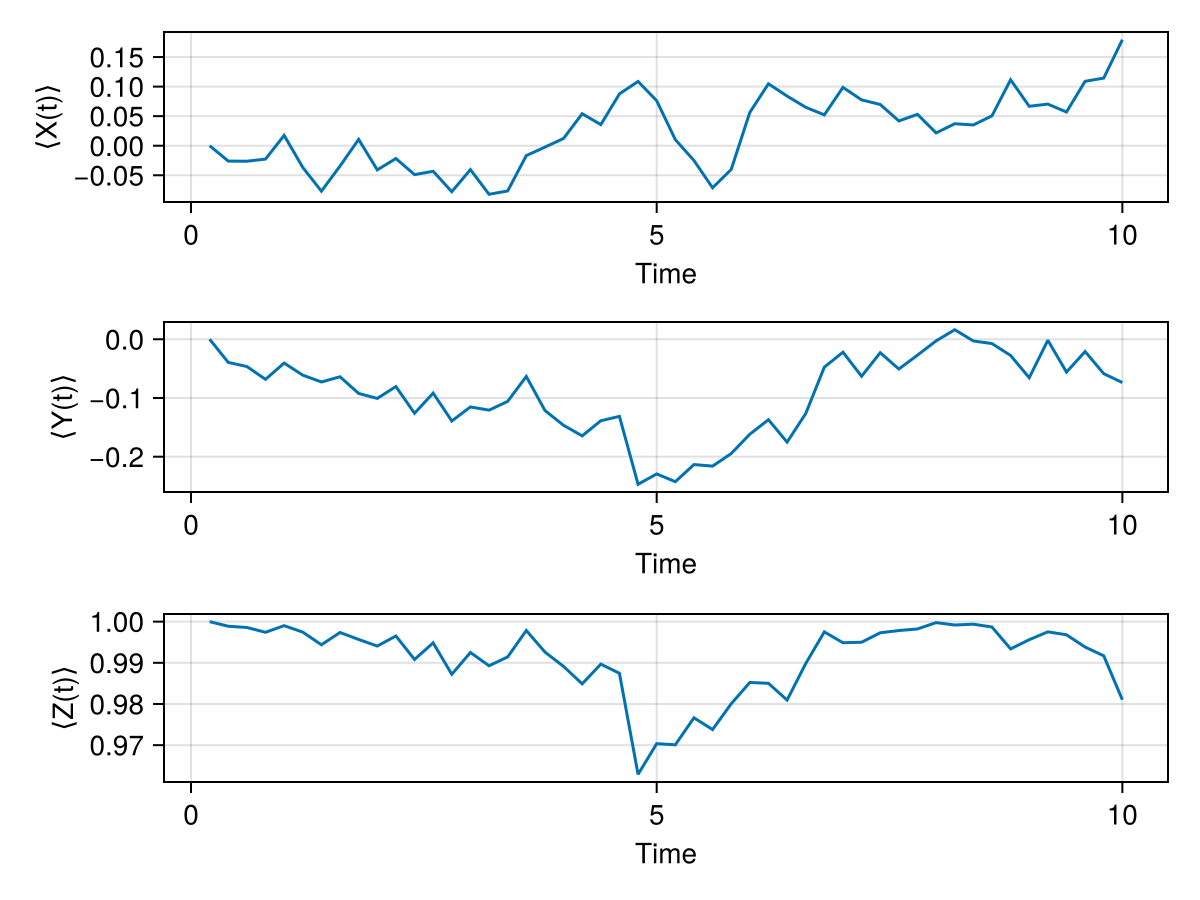

In [287]:
# Plot the trajectory of σₓ
fig1 = Figure()
ax1_1 = fig[1, 1] = Axis(fig1, xlabel = "Time", ylabel = "⟨X(t)⟩")
ax1_2 = fig[2, 1] = Axis(fig1, xlabel = "Time", ylabel = "⟨Y(t)⟩")
ax1_3 = fig[3, 1] = Axis(fig1, xlabel = "Time", ylabel = "⟨Z(t)⟩")

function plot_paulis(a)
    ψ_0 = [1; 0]

    x = Float64[]
    y = Float64[]
    z = Float64[]
    for Ũ⃗ ∈ eachcol(unitary_rollout(a, fill(Δt, T), system))
        U = Matrix{ComplexF64}(iso_vec_to_operator(Ũ⃗))
        ψ_t = U * ψ_0
        push!(x, real(ψ_t'PAULIS[:X]*ψ_t))
        push!(y, real(ψ_t'PAULIS[:Y]*ψ_t))
        push!(z, real(ψ_t'PAULIS[:Z]*ψ_t))
    end
    lines!(ax1_1, Δt * (1:T), x)
    lines!(ax1_2, Δt * (1:T), y)
    lines!(ax1_3, Δt * (1:T), z)
    return fig1
end

plot_paulis(a_guess)

`ForwardDiff.jl` allows us to compute the gradient of a scalar objective--in this case, infidelity.

In [288]:
function f(a)
    Ũ⃗ = unitary_rollout(a, fill(Δt, T), system)
    return 1 - iso_vec_unitary_fidelity(Ũ⃗[:, end], Ũ⃗_goal)
end

∇f(a) = ForwardDiff.gradient(f, a)

∇f (generic function with 1 method)

In [289]:
# Initial condition
aᵢ = copy(a_guess);

In [ ]:
# TODO: Can we write this using fixed point iterations?

0.0012649112411973196


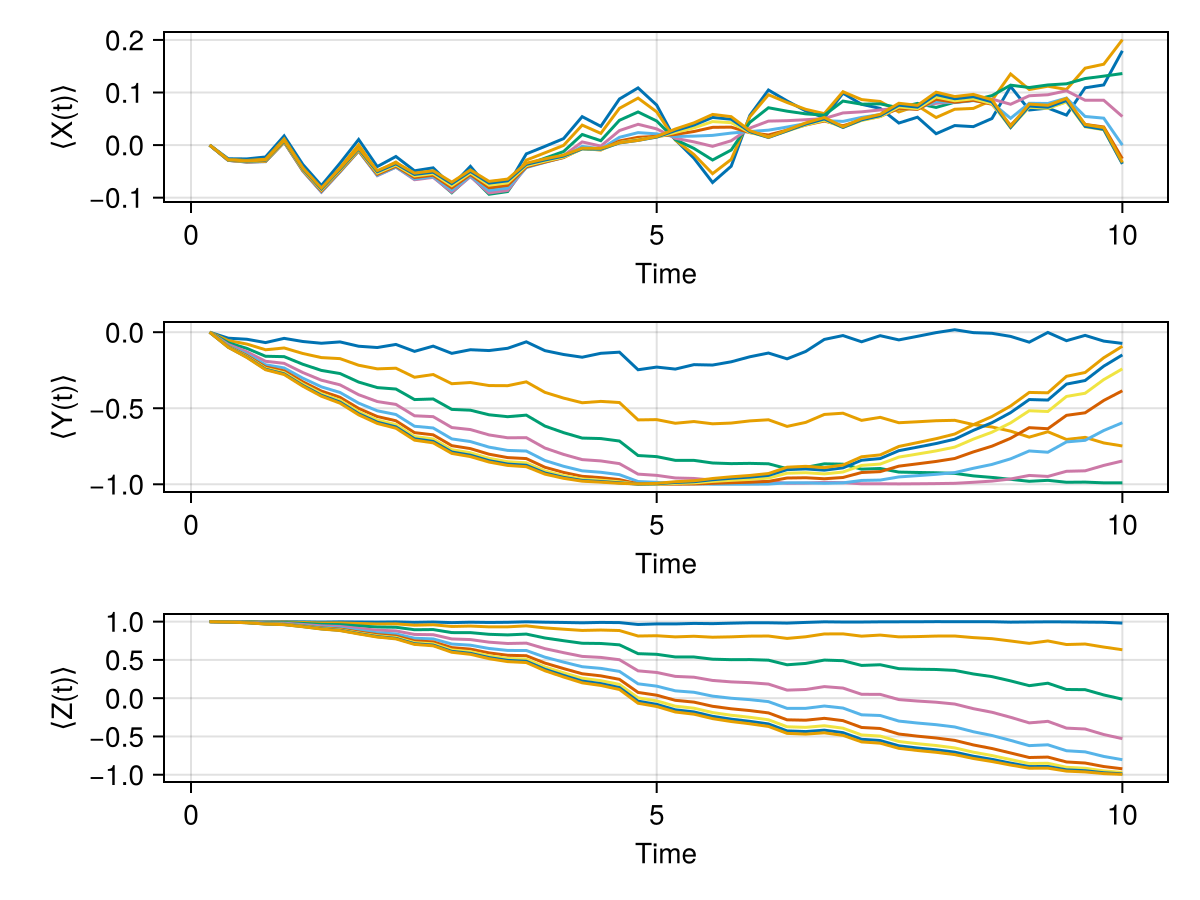

In [297]:
# Gradient descent

## Learning rate
λ = 0.2

## Step
aᵢ₊₁ = aᵢ - λ * ∇f(aᵢ)

f(aᵢ₊₁) |> println
aᵢ .= aᵢ₊₁
plot_paulis(aᵢ₊₁)

The controls seem to do the job! Let's compare the original and the optimized.

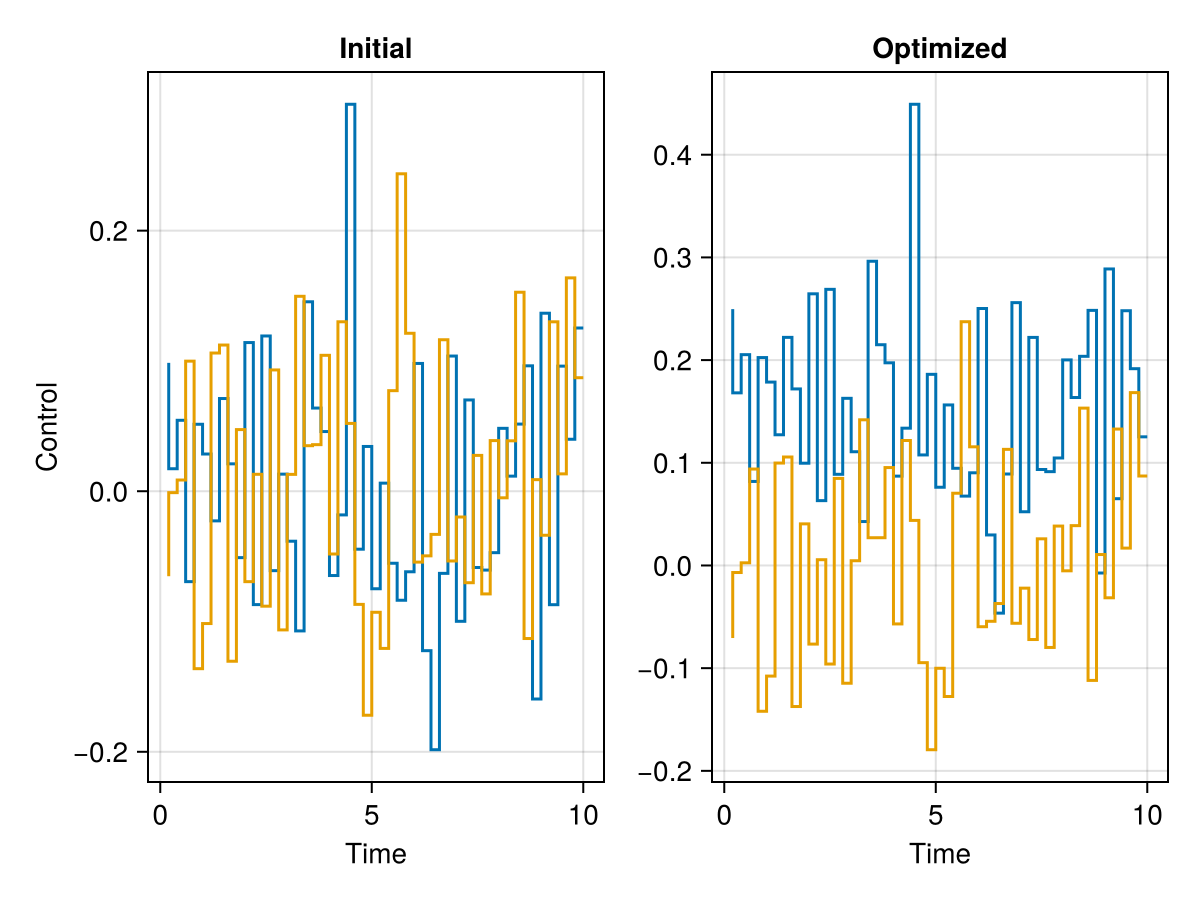

In [298]:
fig2 = Figure()

ax2_1 = fig2[1, 1] = Axis(fig2, title="Initial", xlabel = "Time", ylabel = "Control")
stairs!(ax2_1, Δt * (1:T), a_guess[1, :])
stairs!(ax2_1, Δt * (1:T), a_guess[2, :])

ax2_2 = fig2[1, 2] = Axis(fig2, title="Optimized", xlabel = "Time")
stairs!(ax2_2, Δt * (1:T), aᵢ₊₁[1, :])
stairs!(ax2_2, Δt * (1:T), aᵢ₊₁[2, :])

fig2

You can explore more using Julia, if you'd like:
- https://github.com/JuliaQuantumControl/GRAPE.jl

# Exercises
-----

## Excercise 1.1
**Accelerate GRAPE using Newton's method**

Let's try to tackle second-order GRAPE using Newton's method: https://doi.org/10.1016/j.jmr.2011.07.023

In [ ]:
# TODO: Write the second order method

In [ ]:
# TODO: Write a loop with a fidelity as stopping condition

## Excercise 1.2
**Add a function basis to GRAPE**

The previous control solutions seemed pretty wild. Can we do better? 
- One decade of CRAB: https://doi.org/10.1088/1361-6633/ac723c

What are some other good functions to use?
- Slepians provide bandwidth limits: https://doi.org/10.1103/PhysRevA.97.062346
- Splines minimize the curvature between points: https://github.com/LLNL/Juqbox.jl

In [ ]:
function expand_in_basis(θ::AbstractVector)
    # TODO: Convert the coefficients to a controls matrix
end

In [ ]:
function f2(θ)
    a = expand_in_basis(θ)
    Ũ⃗ = unitary_rollout(a, fill(Δt, T), system)
    return 1 - iso_vec_unitary_fidelity(Ũ⃗[:, end], Ũ⃗_goal)
end

∇f2(a) = ForwardDiff.gradient(f2, a)

A basis is often a proxy for what you actually want.

In **Part II**, we will discuss constrained optimization, which allows you to ask for exactly what you want.

## Exercise 1.3
**Adding regularization to Newton's method**
